<h3><a href="#ChurnPredictionModel" style="text-decoration: none;">Churn Prediction Model</a></h3>

<div>
  <h3><a href="#ImportingLibraries" style="text-decoration: none;">0. Executive Summary</a></h3>

  <h3><a href="#ImportingLibraries" style="text-decoration: none;">1. Importing all Libraries and Setup</a></h3>
  
  <h3><a href="#LoadingPreprocessing" style="text-decoration: none;">2. Loading the Dataset and Preprocessing</a></h3>
  
  <h3><a href="#MergeDatasets" style="text-decoration: none;">3. Merge of the different datasets</a></h3>
  
  <h3><a href="#SplitDatasets" style="text-decoration: none;">4. Split the merged datasets into features and target variable</a></h3>
  
  <h3><a href="#PrepareData" style="text-decoration: none;">5. Preparing the data for modeling</a></h3>
  
  <h3><a href="#Modeling" style="text-decoration: none;">6. Modeling</a></h3>
  <ul style="font-size: 18px;">
    <li><a href="#LogisticRegression" style="text-decoration: none;">6.1 Logistic Regression Model for churn prediction</a></li>
    <li><a href="#RandomForest" style="text-decoration: none;">6.2 Random Forest classifier for churn prediction</a></li>
    <li><a href="#DecisionTree" style="text-decoration: none;">6.3 Decision Tree Model for churn prediction</a></li>
  </ul>
</div>


# 0. Executive Summary

#### Objective:
The Churn Prediction Model goal is to develop a predictive model that can identify customers at high risk of churning as it is the key objective of ClientCo. Churn prediction is crucial for businesses to implement retention strategies proactively and maintain customer loyalty.

#### Methodology:
This section detail the data preparation process, feature selection, and the choice of machine learning models for churn prediction. It would also include model training, validation, and performance evaluation steps, often using different metrics such as accuracy, precision and recall.

#### Key Findings:
The model demonstrated a robust capability to predict churn, highlighting critical factors influencing customer retention. These insights allow for a deeper understanding of customer dissatisfaction points and provide a roadmap for addressing these issues proactively.

#### Conclusions:
The Churn Prediction Model offers a strategic advantage in identifying at-risk customers, enabling targeted interventions to improve customer retention. The model's insights are instrumental in tailoring retention strategies, ultimately contributing to sustained customer loyalty and business growth.




# 1. Importing all Libraries & Setup

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import numpy as np

# 2. Loading the Datasets and Preprocessing

In [ ]:
transaction_data = pd.read_csv('cleaned_transactions.csv')

In [ ]:
# converting the column date_order and date_invoice from object (yyyy-mm-dd) to datetime
transaction_data['date_order'] = pd.to_datetime(transaction_data['date_order'])
transaction_data['date_invoice'] = pd.to_datetime(transaction_data['date_invoice'])

# Convert order_processing_time and purchase_interval to appropriate data type (float32)
transaction_data['order_processing_time'] = transaction_data['order_processing_time'].astype('float32')
transaction_data['purchase_interval'] = transaction_data['purchase_interval'].astype('float32')

# Convert product_id, client_id, and branch_id to unsigned integer data type
transaction_data['product_id'] = transaction_data['product_id'].astype('uint32')
transaction_data['client_id'] = transaction_data['client_id'].astype('uint32')
transaction_data['branch_id'] = transaction_data['branch_id'].astype('uint16')

# Convert sales_net to appropriate data type, considering its currency (e.g., float16 or float32)
transaction_data['sales_net'] = transaction_data['sales_net'].astype('float32')

# Convert quantity to appropriate data type, considering it's an integer
transaction_data['quantity'] = transaction_data['quantity'].astype('uint16')

# Convert month_year to period[M]
transaction_data['month_year'] = pd.to_datetime(transaction_data['month_year']).dt.to_period('M')

# Convert previous_order_date to datetime64[ns]
transaction_data['previous_order_date'] = pd.to_datetime(transaction_data['previous_order_date'])

In [ ]:
rfm_score = pd.read_csv('rfm_score.csv')

In [ ]:
rfm_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       170589 non-null  int64  
 1   date_order_max  170589 non-null  object 
 2   Recency         170589 non-null  int64  
 3   T               170589 non-null  int64  
 4   MonetaryValue   170589 non-null  float64
 5   Frequency       170589 non-null  int64  
 6   RecencyScore    170589 non-null  int64  
 7   FrequencyScore  170589 non-null  int64  
 8   MonetaryScore   170589 non-null  int64  
 9   RFM_Segment     170589 non-null  int64  
 10  RFM_Score       170589 non-null  int64  
 11  RFM_Level       170589 non-null  object 
 12  Is_Churned      170589 non-null  bool   
dtypes: bool(1), float64(1), int64(9), object(2)
memory usage: 15.8+ MB


In [ ]:
# correlation between columns 'Recency' and 'Is_Churned'
print(rfm_score[['Recency', 'Frequency', 'MonetaryValue', 'RecencyScore', 'Is_Churned']].corr())

                Recency  Frequency  MonetaryValue  RecencyScore  Is_Churned
Recency        1.000000  -0.167728      -0.146497     -0.833799    0.840026
Frequency     -0.167728   1.000000       0.862861      0.277720   -0.163516
MonetaryValue -0.146497   0.862861       1.000000      0.240146   -0.143196
RecencyScore  -0.833799   0.277720       0.240146      1.000000   -0.817549
Is_Churned     0.840026  -0.163516      -0.143196     -0.817549    1.000000


In [ ]:
# dropping columns 'Recency', and 'RecencyScore' from rfm_score as they are highly correlated with 'Is_Churned'
rfm_score = rfm_score.drop(['Recency', 'RecencyScore'], axis=1)

In [ ]:
rfm_score.columns

Index(['client_id', 'date_order_max', 'T', 'MonetaryValue', 'Frequency',
       'FrequencyScore', 'MonetaryScore', 'RFM_Segment', 'RFM_Score',
       'RFM_Level', 'Is_Churned'],
      dtype='object')

In [ ]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date_order             datetime64[ns]
 1   date_invoice           datetime64[ns]
 2   product_id             uint32        
 3   client_id              uint32        
 4   sales_net              float32       
 5   quantity               uint16        
 6   order_channel          object        
 7   branch_id              uint16        
 8   month_year             period[M]     
 9   order_processing_time  float32       
 10  previous_order_date    datetime64[ns]
 11  purchase_interval      float32       
dtypes: datetime64[ns](3), float32(3), object(1), period[M](1), uint16(2), uint32(2)
memory usage: 3.8+ GB


In [ ]:
# Convert client_id in rfm_score to uint32 to match transaction_data and convert date_order_max to datetime64[ns]
rfm_score['client_id'] = rfm_score['client_id'].astype('uint32')
rfm_score['date_order_max'] = pd.to_datetime(rfm_score['date_order_max'])

# Verify the conversion
print(f"rfm_score client_id type after conversion: {rfm_score['client_id'].dtype}")
print(f"rfm_score date_order_max type after conversion: {rfm_score['date_order_max'].dtype}")

rfm_score client_id type after conversion: uint32
rfm_score date_order_max type after conversion: datetime64[ns]


# 3. Merge of the different datasets

## Step 1: Implement the frequency counts for 0 and negative sales in the transaction_data

In [ ]:
transaction_data['is_negative_sale'] = transaction_data['sales_net'] < 0
transaction_data['is_zero_sale'] = transaction_data['sales_net'] == 0

## Step 2: Perform the temporal split based on date_order

In [ ]:
split_date = transaction_data['date_order'].max() - timedelta(weeks=26)

pre_26w_data = transaction_data[transaction_data['date_order'] <= split_date]
post_26w_data = transaction_data[transaction_data['date_order'] > split_date]

## Step 3: Aggregate the split datasets by client_id, creating features that reflect transaction behaviour and inactivity

In [ ]:
# Adjusting the aggregation for pre_26w_data and post_26w_data
def aggregate_data(data):
    aggregated_data = data.groupby('client_id').agg({
        'sales_net': ['sum', 'mean'],
        'is_negative_sale': ['mean', 'sum'],
        'is_zero_sale': ['mean', 'sum'],
        'quantity': ['sum', 'mean'],
        'order_processing_time': ['mean', 'std'],
        'order_channel': lambda x: x.mode()[0] if not x.mode().empty else None
    }).reset_index()


    aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]
    return aggregated_data

aggregated_pre_26w = aggregate_data(pre_26w_data)
aggregated_post_26w = aggregate_data(post_26w_data)

In [ ]:
# Rename 'client_id_' to 'client_id' in both aggregated DataFrames
aggregated_pre_26w.rename(columns={'client_id_': 'client_id'}, inplace=True)
aggregated_post_26w.rename(columns={'client_id_': 'client_id'}, inplace=True)

## Step 4: Merge the aggregated datasets with the rfm_score

In [ ]:
# Ensuring inner join to match client_ids
merged_pre_26w_with_rfm = pd.merge(aggregated_pre_26w, rfm_score, on='client_id', how='inner')
merged_post_26w_with_rfm = pd.merge(aggregated_post_26w, rfm_score, on='client_id', how='inner')

In [ ]:
# Checking for null values in the transformed data
print(f"Missing values in merged_pre_26w_with_rfm: {merged_pre_26w_with_rfm.isna().sum()}")
print(f"Missing values in merged_pre_26w_with_rfm: {merged_post_26w_with_rfm.isna().sum()}")

Missing values in merged_pre_26w_with_rfm: client_id                        0
sales_net_sum                    0
sales_net_mean                   0
is_negative_sale_mean            0
is_negative_sale_sum             0
is_zero_sale_mean                0
is_zero_sale_sum                 0
quantity_sum                     0
quantity_mean                    0
order_processing_time_mean       0
order_processing_time_std     6190
order_channel_<lambda>           0
date_order_max                   0
T                                0
MonetaryValue                    0
Frequency                        0
FrequencyScore                   0
MonetaryScore                    0
RFM_Segment                      0
RFM_Score                        0
RFM_Level                        0
Is_Churned                       0
dtype: int64
Missing values in merged_pre_26w_with_rfm: client_id                        0
sales_net_sum                    0
sales_net_mean                   0
is_negative_sale_mean     

In [ ]:
# Removing column 'order_processing_time_std' from the merged data as it has many missing values and not important
merged_pre_26w_with_rfm.drop(columns=['order_processing_time_std'], inplace=True)
merged_post_26w_with_rfm.drop(columns=['order_processing_time_std'], inplace=True)

In [ ]:
print(f"Missing values in merged_pre_26w_with_rfm: {merged_pre_26w_with_rfm.isna().sum().sum()}")
print(f"Missing values in merged_pre_26w_with_rfm: {merged_post_26w_with_rfm.isna().sum().sum()}")

Missing values in merged_pre_26w_with_rfm: 0
Missing values in merged_pre_26w_with_rfm: 0


In [ ]:
print(merged_pre_26w_with_rfm['order_channel_<lambda>'])

0             by phone
1         at the store
2             by phone
3         at the store
4         at the store
              ...     
158313    at the store
158314    at the store
158315    at the store
158316    at the store
158317        by phone
Name: order_channel_<lambda>, Length: 158318, dtype: object


# 4. Split the merged datasets into features and target variable

In [ ]:
merged_pre_26w_with_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158318 entries, 0 to 158317
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   client_id                   158318 non-null  uint32        
 1   sales_net_sum               158318 non-null  float32       
 2   sales_net_mean              158318 non-null  float32       
 3   is_negative_sale_mean       158318 non-null  float64       
 4   is_negative_sale_sum        158318 non-null  int64         
 5   is_zero_sale_mean           158318 non-null  float64       
 6   is_zero_sale_sum            158318 non-null  int64         
 7   quantity_sum                158318 non-null  uint64        
 8   quantity_mean               158318 non-null  float64       
 9   order_processing_time_mean  158318 non-null  float32       
 10  order_channel_<lambda>      158318 non-null  object        
 11  date_order_max              158318 non-

In [ ]:
# Drop the target variable to create features DataFrame and define the target
X = merged_pre_26w_with_rfm.drop(['Is_Churned'], axis=1)
y = merged_pre_26w_with_rfm['Is_Churned']

# 5. Preparing the data for Modeling

- The target variable Is_Churned indicates whether a client will churn in the next 26 weeks
- Handling categorical column 'RFM_Level' with ColumnTransformer

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

datetime_cols = [col for col in X_train.columns if X_train[col].dtype == 'datetime64[ns]']
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and col not in datetime_cols]
numeric_cols = [col for col in X_train.columns if col not in categorical_cols + datetime_cols + ['client_id']]

# Separate transformer for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Separate transformer for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the training data; transform the test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### The above code returns numpy arrays, reconstructing the DataFrame with the original column names:

In [ ]:
onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
transformed_columns = np.concatenate([numeric_cols, onehot_columns])

# Since datetime columns were not transformed or included in the ColumnTransformer, they are not in the transformed data
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns, index=X_test.index)

In [ ]:
#New Dataframe
X_train_transformed_df

,sales_net_sum,sales_net_mean,is_negative_sale_mean,is_negative_sale_sum,is_zero_sale_mean,is_zero_sale_sum,quantity_sum,quantity_mean,order_processing_time_mean,T,...,RFM_Segment,RFM_Score,order_channel_<lambda>_by phone,order_channel_<lambda>_during the visit of a sales rep,order_channel_<lambda>_online,order_channel_<lambda>_other,RFM_Level_Champions,RFM_Level_Hibernating,RFM_Level_Need Attention,RFM_Level_Potential Loyalist
26141,-0.225860,-0.149207,0.075229,-0.165916,-0.365761,-0.229588,-0.131886,-0.120775,-0.258785,-0.482563,...,-0.654834,-0.565578,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12676,-0.235323,-0.172234,4.652944,-0.046202,-0.630083,-0.251121,-0.134590,-0.114490,1.588078,0.633737,...,-1.353018,-1.080292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42789,0.117714,-0.091345,-0.038535,0.312941,-0.441842,-0.078853,-0.066118,-0.110938,0.026653,0.716426,...,0.125862,0.978564,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
146831,-0.091010,-0.043363,-0.366937,-0.185868,-0.539973,-0.229588,-0.091427,-0.057481,-0.224787,0.695753,...,0.056043,0.463850,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54135,-0.230536,-0.035503,-0.496986,-0.225773,-0.630083,-0.251121,-0.136234,-0.133523,-0.360404,-0.179371,...,-1.416489,-1.337649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.175862,-0.082148,0.280781,-0.086106,-0.630083,-0.251121,-0.131155,-0.129534,0.094460,0.737098,...,0.056043,0.463850,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
103694,-0.227111,-0.112457,-0.496986,-0.225773,1.532552,-0.186521,-0.134912,-0.122689,-0.356108,-2.343064,...,-0.654834,-0.565578,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
131932,-0.144947,0.049169,-0.144854,-0.185868,-0.630083,-0.251121,-0.134474,-0.136889,0.570162,0.592392,...,0.627284,0.463850,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
146867,-0.218750,1.193829,-0.496986,-0.225773,-0.630083,-0.251121,-0.136446,-0.142417,-0.017736,0.247855,...,-1.416489,-1.337649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Modeling

## 6.1. Logistic Regression Model for churn prediction

### Step 1: Train the Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_transformed_df, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_transformed_df)
y_pred_proba = model.predict_proba(X_test_transformed_df)[:, 1]  # Probability estimates for the positive class

### Step 2: Evaluate the Model's Performance


In [ ]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9570174330469934
ROC AUC Score: 0.9895347069096705
Confusion Matrix:
 [[18576  1354]
 [    7 11727]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.93      0.96     19930
        True       0.90      1.00      0.95     11734

    accuracy                           0.96     31664
   macro avg       0.95      0.97      0.95     31664
weighted avg       0.96      0.96      0.96     31664



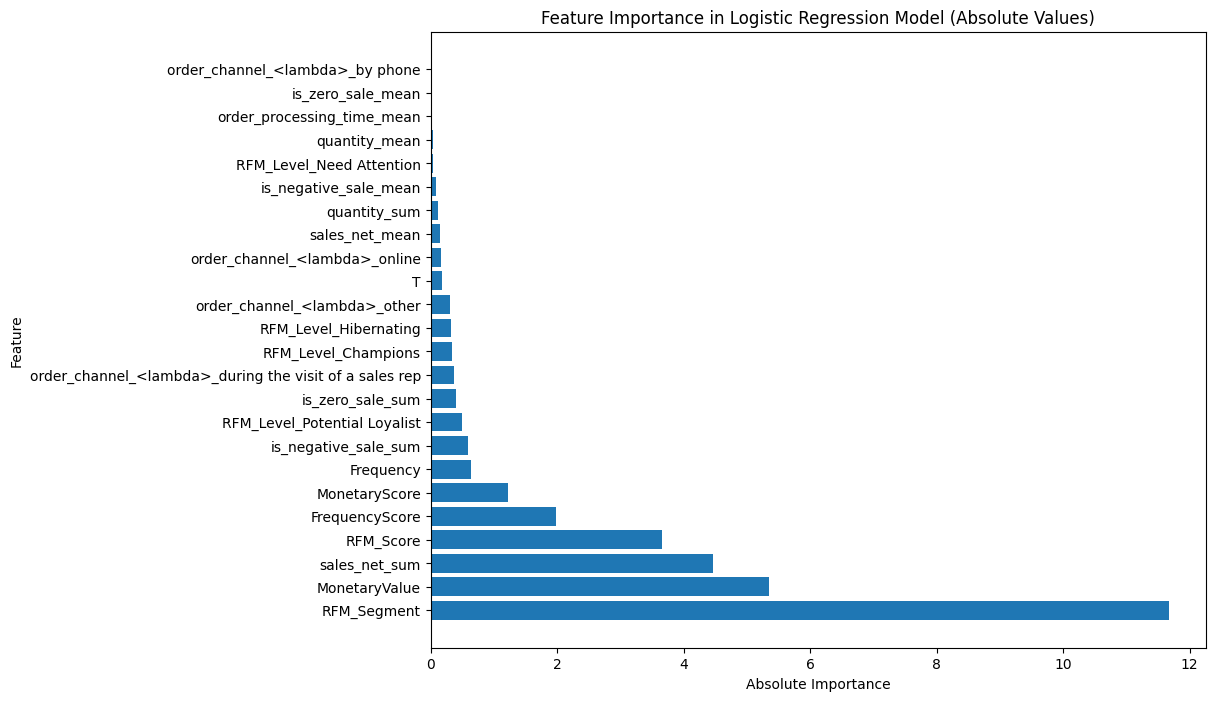

In [ ]:
# Extracting the coefficients of the logistic regression model
coefficients = model.coef_[0]

feature_importance = pd.DataFrame(X_train_transformed_df.columns, columns=['Feature'])
feature_importance['Importance'] = abs(coefficients)  # Using absolute values

# Sorting the features by their importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model (Absolute Values)')
plt.show()

## 6.2. Random Forest classifier for churn prediction

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train_transformed_df, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test_transformed_df)
y_pred_proba_rf = random_forest_model.predict_proba(X_test_transformed_df)[:, 1]  # Probability estimates for the positive class

# Evaluation metrics:
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy Score: 0.9580596260737746
Random Forest ROC AUC Score: 0.9931209570124034
Random Forest Confusion Matrix:
 [[18768  1162]
 [  166 11568]]
Random Forest Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.94      0.97     19930
        True       0.91      0.99      0.95     11734

    accuracy                           0.96     31664
   macro avg       0.95      0.96      0.96     31664
weighted avg       0.96      0.96      0.96     31664



In [ ]:
feature_importances = random_forest_model.feature_importances_
feature_names = X_train_transformed_df.columns

importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order for better visualization
sorted_importances = importances.sort_values(ascending=False)


#### Important features:

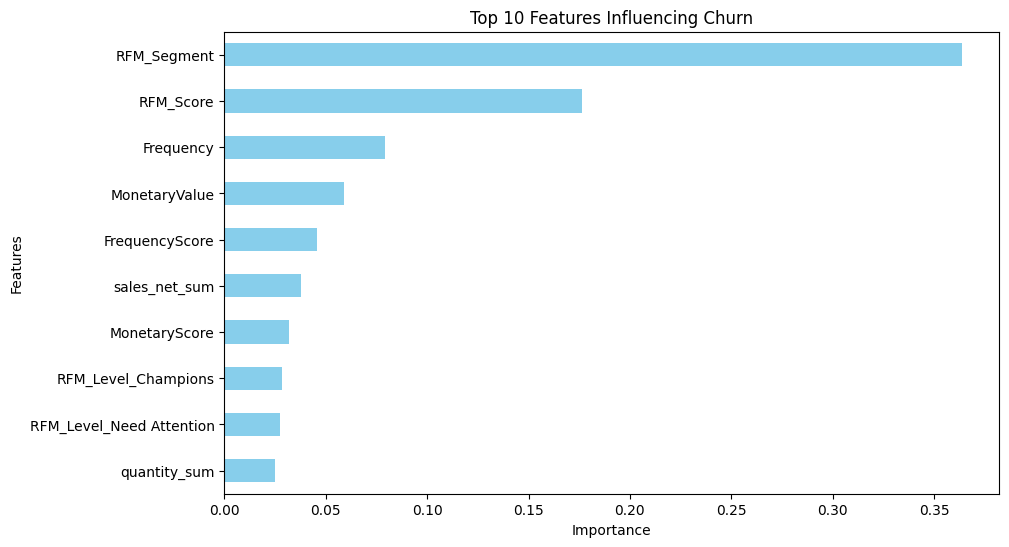

In [ ]:
import seaborn as sns

top_n = 10
sorted_importances[:top_n].plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Features Influencing Churn')
plt.gca().invert_yaxis()
plt.show()

## 6.3. Decision Tree Model for churn prediction

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)  # Limit depth for visualization purposes

# Train the model
decision_tree_model.fit(X_train_transformed_df, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

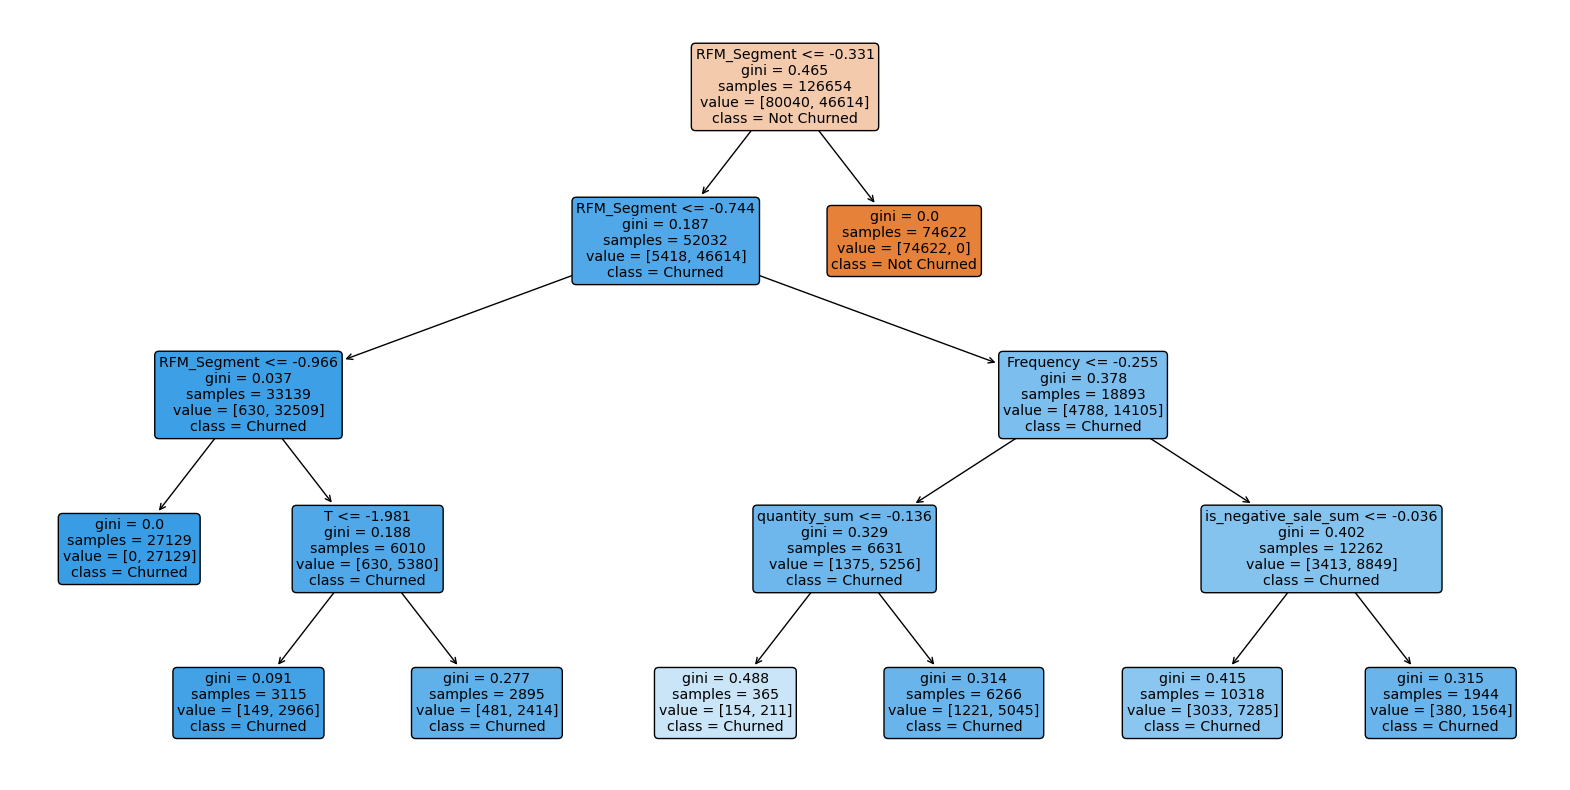

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(decision_tree_model,
          filled=True,
          rounded=True,
          class_names=['Not Churned', 'Churned'],
          feature_names=X_train_transformed_df.columns,
          max_depth=4)
plt.show()

In [ ]:
from sklearn.tree import export_text

# Generate the text representation of the decision tree
decision_tree_text = export_text(decision_tree_model, feature_names=list(X_train_transformed_df.columns), max_depth=3)  # Adjust max_depth as needed

print(decision_tree_text)

|--- RFM_Segment <= -0.33
|   |--- RFM_Segment <= -0.74
|   |   |--- RFM_Segment <= -0.97
|   |   |   |--- class: True
|   |   |--- RFM_Segment >  -0.97
|   |   |   |--- T <= -1.98
|   |   |   |   |--- class: True
|   |   |   |--- T >  -1.98
|   |   |   |   |--- class: True
|   |--- RFM_Segment >  -0.74
|   |   |--- Frequency <= -0.26
|   |   |   |--- quantity_sum <= -0.14
|   |   |   |   |--- class: True
|   |   |   |--- quantity_sum >  -0.14
|   |   |   |   |--- class: True
|   |   |--- Frequency >  -0.26
|   |   |   |--- is_negative_sale_sum <= -0.04
|   |   |   |   |--- class: True
|   |   |   |--- is_negative_sale_sum >  -0.04
|   |   |   |   |--- class: True
|--- RFM_Segment >  -0.33
|   |--- class: False

